<a href="https://colab.research.google.com/github/rajeevfromkrec/pytorch/blob/master/Transfer%20learning%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-08-01 16:08:56--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.166.17, 13.224.166.66, 13.224.166.129, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.166.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   157MB/s    in 0.3s    

2020-08-01 16:08:56 (157 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [2]:
!ls

hymenoptera_data.zip  sample_data


In [3]:
import zipfile
from zipfile import ZipFile

In [4]:
with ZipFile('hymenoptera_data.zip', 'r') as zipobj:
  zipobj.extractall()

In [37]:
import os
import torch
import torchvision
from torchvision import datasets,transforms ,models
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid
import torch.nn.functional as F



In [6]:
os.listdir('hymenoptera_data/train')

['bees', 'ants']

In [7]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms= tt.Compose([
                        tt.RandomResizedCrop(224),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        
])

val_tfms= tt.Compose([
                        tt.Resize(256),
                        tt.CenterCrop(224),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        
])

In [8]:
train_ds= datasets.ImageFolder('hymenoptera_data/train' ,train_tfms)
val_ds= datasets.ImageFolder('hymenoptera_data/val' ,val_tfms)

In [9]:
image,label=train_ds[0]

In [10]:
print(train_ds.classes)

['ants', 'bees']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


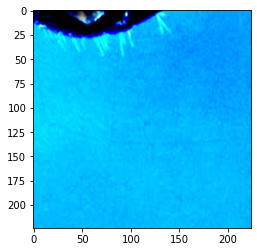

In [11]:
print(label)
plt.imshow(image.permute(1,2,0))


In [12]:
train_loader= DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=4,pin_memory=True)
val_loader= DataLoader(val_ds,batch_size=8,num_workers=4,pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0, 0, 1, 0, 1, 0, 0])


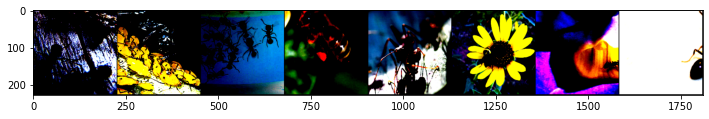

In [13]:
for images,labels in train_loader:
  print(labels)
  fig,ax=plt.subplots(figsize=(12,6))
  plt.imshow(make_grid(images,nrow=8).permute(1,2,0))
  break

In [14]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
model=models.resnet18(pretrained=True)
num_ftrs=model.fc.in_features
print(num_ftrs)
model.fc=nn.Linear(num_ftrs,2)
num_ftrs=model.fc.in_features
print(num_ftrs)

model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



512
512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
for images,labels in train_loader:
  out=model(images)
  _,preds=torch.max(out,dim=1)
  print(out)
  print(preds)
  break

tensor([[ 1.1036, -0.2358],
        [ 0.1641, -0.3760],
        [-0.2255, -0.2093],
        [ 0.4244, -0.0360],
        [-0.1459, -0.0078],
        [ 0.2283,  0.2490],
        [ 0.5928,  0.2506],
        [ 0.0463,  0.2098]], grad_fn=<AddmmBackward>)
tensor([0, 0, 1, 0, 1, 1, 0, 1])


In [22]:
 def training_step(model, batch):
        images, labels = batch 
        out = model(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
 def validation_step(model, batch):
        images, labels = batch 
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
def validation_epoch_end( outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
def epoch_end( epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))  

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))  

In [42]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[validation_step(model,batch) for batch in val_loader]
  return validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                          weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history=[]
  optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
    model.train()
    train_losses=[]
    lrs=[]
    for batch in train_loader:
      loss=training_step(model,batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(),grad_clip)
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()
    

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    epoch_end(epoch, result)
    history.append(result)
  return history

In [45]:
epochs = 8
max_lr = 0.01
grad_clip = False
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history=[]
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)